# Assignment 4: Multi-Output Networks and Batch Processing


The goal of this exercise is to get to know some regularization techniques when implementing deep learning methods.
For this purpose, we select a dataset that contains data in different formats, some binary ($x_d \in \{-1,1\}$) and some numerical ($x_d\in \mathbb N$); and some are categorical, which we ignore for now.
As target values, this dataset contains three numerical outputs, so, $\vec t \in \mathbb R^3$ for each sample.
These target values should be approximated with a two-layer multi-output network that we will train with the $\mathcal J^{L_2}$ loss.



Remember to make use of `numpy` in the matrix calculation, e.g. `numpy.dot`, `numpy.exp`, `numpy.mean` 


## Dataset

The dataset of our choice is the Student Performance estimation dataset that was collected in Portugal in two different schools and with two different subjects, i.e., math and Portuguese (the mother tongue).
The dataset contains many different inputs such as a binary representation of the school, gender, family sizes, and alike, as well as numerical representations of age, travel time, and alcohol consumption.
The dataset also includes some categorical data, which we skip in this assignment.
See https://archive.ics.uci.edu/ml/datasets/Student+Performance for more information on the dataset.
As a start, we will rely on the Portuguese performance (`"por"`), but you can also try to use the Math samples (`"mat"`).

### Task 1: Dataset Loading


Load the dataset from files and provide the input matrix $\mathbf X \in \mathbb R^{(D+1)\times N}$ and the output matrix $\mathbf T \in \mathbb R^{O\times N}$.

Due to the difficulty of the task, most of the implementation is provided.
The implementation is very literal and, therefore, hopefully readable, while maybe not the most efficient.

We skip categorical inputs (indexes 8-11) for now.
All other entries are converted either into binary $(-1,1)$ or into an integer range $(0,1,\ldots)$.
The three outputs range between 0 and 20 each. The bias value for $x_0=1$ is also already included.
You just need to make sure that the data $(X,T)$ is returned in the desired format.

In [1]:
import math
import numpy
import os

# Dataset origin: https://archive.ics.uci.edu/ml/datasets/Student+Performance

def dataset(course="por"):
    # load dataset and provide input and target data
    # possible data files are "mat" and "por"

    # download data file from URL
    dataset_zip_file = "student.zip"
    if not os.path.exists(dataset_zip_file):
        import urllib.request
        urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00320/student.zip", dataset_zip_file)
        print ("Downloaded datafile", dataset_zip_file)

    import zipfile
    import csv
    import io

    # collect inputs
    inputs = []
    targets = []
    # some default values: yes=1, no=-1
    yn = {"yes":1.,"no":-1.}
    # read through dataset (without actually unzippiung to a file):
    # ... open zip file
    zip = zipfile.ZipFile(dataset_zip_file)
    # ... open data file inside of zip file and convert bytes to text
    datafile = io.TextIOWrapper(zip.open(os.path.join(F"student-{course}.csv"), 'r'))
    # ... read through the lines via CSV reader, using the correct delimited
    reader = csv.reader(datafile, delimiter=";")
    # ... skip header line
    next(reader)
    for splits in reader:
    # read input values
        inputs.append([
        1.,                             #### BIAS ####
        {"GP":1.,"MS":-1.}[splits[0]],  # school
        {"M":1.,"F":-1.}[splits[1]],    # gender
        float(splits[2]),               # age
        {"U":1.,"R":-1.}[splits[3]],    # address
        {"LE3":1.,"GT3":-1.}[splits[4]],# family size
        {"T":1.,"A":-1.}[splits[5]],    # parents living together
        float(splits[6]),               # mother education
        float(splits[7]),               # father education
        # skip categorical values
        float(splits[12]),              # travel time
        float(splits[13]),              # study time
        float(splits[14]),              # failures
        yn[splits[15]],                 # extra support
        yn[splits[16]],                 # family support
        yn[splits[17]],                 # paid support
        yn[splits[18]],                 # activities
        yn[splits[19]],                 # nursery school
        yn[splits[20]],                 # higher education
        yn[splits[21]],                 # internet
        yn[splits[22]],                 # romantic
        float(splits[23]),              # family relation
        float(splits[24]),              # free time
        float(splits[25]),              # going out
        float(splits[26]),              # workday alcohol
        float(splits[27]),              # weekend alcohol
        float(splits[28]),              # health
        float(splits[29]),              # absences
    ])

        # read targets values
        targets.append([
            float(splits[30]),              # grade for primary school
            float(splits[31]),              # grade for secondary school
            float(splits[32]),              # grade for tertiary school
        ])
    
    inputs = numpy.asarray(inputs).transpose()
    targets = numpy.asarray(targets).transpose()
    
    print(F"Loaded dataset with {len(targets)} samples")
    return inputs, targets

### Test 1: Assert Valid Outputs

This test will check the dimension of the loaded dataset, i.e. $\mathbf X\in \mathbb R^{(D+1)\times N}$ and $\mathbf T \in \mathbb R^{O\times N}$, and also assure that all target data is in the range $t\in[0,20]$.

Please make sure that your implementation can pass these tests before moving to the next task

In [2]:
X, T = dataset("por")
print(X)

assert numpy.all(T >= 0) and numpy.all(T <= 20)

assert X.shape[0] == 27
assert T.shape[0] == 3
assert T.shape[1] == X.shape[1]

Loaded dataset with 3 samples
[[ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1.  1.  1.]
 ...
 [ 1.  1.  3. ...  1.  4.  4.]
 [ 3.  3.  3. ...  5.  2.  5.]
 [ 4.  2.  6. ...  6.  6.  4.]]


### Task 2: Input Data Standardization

Since the data is in different input regimes, we want to standardize the data.
For this purpose, we need to compute the mean and the standard deviation of the data for each input dimension.
Then, we implement a function to perform the standardization of the data using the previously computed mean and standard deviation. Make sure that you handle the bias neuron $x_0$ correctly.

Please note that `numpy` has all the functionality that you need.

In [3]:
# compute mean and standard deviation over dataset
mean = numpy.mean(X, axis = 1)
std = numpy.std(X, axis = 1)

# assure to handle x_0 correctly


def standardize(x, mean, std):
    # standardize the given data with the given mean and standard deviation
    col_ls = list()
    for idx in range(len(x)):
        value_ls = list()
        if idx == 0:
            for jdx in range(len(x[idx])):
                value_ls.append(0.0)
        else:
            for value in x[idx]:
                x_std = (value - mean[idx]) / std[idx]
                value_ls.append(round(x_std, 2))
        col_ls.append(value_ls)
    
    X_std = numpy.asarray(col_ls)
    return X_std
        

# standardize our dataset
X = standardize(X, mean, std)


### Task 3: Batch Processing

In order to run stochastic gradient descent, we need to split our dataset into batches of a certain batch size $B$. Implement a function that turns the dataset $(X,T)$ into batches of a certain batch size $B$.
Implement this function as a generator function, i.e., use ``yield`` instead of ``return``.
Circulate the dataset afresh when all data is consumed, and shuffle the data in each epoch.
Make sure that you yield both the input batch and the target batch.

In [4]:
from copy import deepcopy
def batch(X, T, batch_size=16):
    shuffle = numpy.random.permutation(T.shape[1])
    idx = 0
    while True:
        # shuffle dataset in each epoch
        yield X[:,shuffle[idx:idx + batch_size]], T[:,shuffle[idx:idx + batch_size]]
        idx += batch_size
        if (idx >= T.shape[1]):
            shuffle = numpy.random.permutation(T.shape[1])
            idx = 0

### Test 2: Test your Batches

This test is to assure that your batch generation function works as expected. 
We define some test data for this purpose.
The code below checks whether your batch function returns batches with correct content, i.e., $(\vec x, \vec t)$-alignment. 
It also checks that the batches are in the correct dimensions, i.e., that $\mathbf X \in \mathbb R^{(D+1)\times B}$ and $\mathbf T \in \mathbb R^{O\times B}$.

Make sure you can pass this test before moving forward.

In [5]:
XX = numpy.array([[i] * 5 for i in range(50)]).T
TT = numpy.array([[i] for i in range(10,60)]).T

for counter, (x,t) in enumerate(batch(XX, TT, 10)):
    assert x.shape[0] == 5
    assert x.shape[1] == 10
    assert t.shape[0] == 1
    assert t.shape[1] == 10
    assert numpy.all(x == t-10)
    if counter == 20: break

### Gradient Descent

To train a two-layer multi-output regression network, we need to implement some functions.
The network output is computed in three steps:

  * Compute network activation for a batch of inputs $\mathbf X$: $\mathbf A = \mathbf W^{(1)}\mathbf X$
  * Call the activation function element-wise: $\mathbf H = g(\mathbf A)$. Here, we rely on the logistic activation function $\sigma$. Assure that the hidden neuron bias $\mathbf H_{0,:}$ is set appropriately.
  * Compute the output $\mathbf Y$ of the batch: $\mathbf Y = \mathbf W^{(2)}\mathbf H$.

### Task 4: Multi-Output Network

Implement a multi-target network that computes the output matrix $\mathbf Y$ for a given input dataset/batch $\mathbf X$ and given parameters $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$ using `numpy` operations. 
The function should return both the output $\mathbf Y$ and the output of the hidden units $\mathbf H$ since we will need these in gradient descent. Select the logistic function $\sigma$ as the activation function.

In [6]:
def network(X, Theta):
    W1, W2 = Theta

    # print(X.shape)
    # compute activation
    A = numpy.dot(W1,X)
    
    # compute hidden unit output
    H = 1 / (1 + numpy.exp(-A))
    
    # print(H.shape)
    
    # compute output
    Y = numpy.dot(W2,H)
    
    return Y, H

### Task 5: Loss Implementation

Implement a loss function that returns the squared loss $\mathcal J^{L_2} = \frac1B \|\mathbf Y - \mathbf T\|_F^2$ for given network outputs $\mathbf Y$ and target values $\mathbf T$.
Use `numpy` or `scipy` functionality for this task.

In [12]:
def loss(Y, T):
    loss = (1/T.shape[1])*numpy.sum(numpy.square(Y-T))
    return loss

### Task 6: Gradient Implementation

Implement a function that computes and returns the gradient for a given batch $(\mathbf X, \mathbf T)$, the given network outputs $\mathbf Y$ and $\mathbf H$ as well as current parameters $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$.
Make sure to compute the gradient with respect to both weight matrices. Remember that we have used $\sigma$ as the activation function.
Implement the function using the fast version provided in the lecture and make use of `numpy` operations.

In [13]:
print(X, T)

[[ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.73  0.73  0.73 ... -1.37 -1.37 -1.37]
 [-0.83 -0.83 -0.83 ... -0.83  1.2   1.2 ]
 ...
 [-1.   -1.    0.56 ... -1.    1.34  1.34]
 [-0.37 -0.37 -0.37 ...  1.01 -1.06  1.01]
 [ 0.07 -0.36  0.5  ...  0.5   0.5   0.07]] [[ 0.  9. 12. ... 11. 10. 10.]
 [11. 11. 13. ... 12. 10. 11.]
 [11. 11. 12. ...  9. 10. 11.]]


In [14]:
def gradient(X, T, Y, H, Theta):
    W1, W2 = Theta
    N = T.shape[1]
    # print(Y.shape, T.shape)
    
    # first layer gradient
    g1 = (2/N)*(numpy.dot(numpy.dot(numpy.dot(numpy.dot(W2.T, Y-T), H.T), 1-H), X.T))
 
    # second layer gradient
    g2 = (2/N)*(numpy.dot(Y-T, H.T))
    
  
    return g1, g2

### Task 7: Iterative Gradient Descent


Implement gradient descent for a given number of 10'000 epochs (**not batches!**) using given initial parameters $\Theta$ and a given batch size $B$, as well as a learning rate of $\eta=0.001$.

Make use of the standardized dataset from Task 2, split into batches with the function from Task 3, the network from Task 4, the loss from Task 5, and the gradient from Task 6.

Make sure that the network output $\mathbf Y$ and the hidden unit output $\mathbf H$ are computed only once for each batch. After applying gradient descent, add an option to use momentum learning with the given parameter `mu`.
At the end of each epoch, compute and store the loss values for each batch in a list, and this list will be returned at the end.

How many iterations do we need when $B < N$? How can you know whether your current batch is the last one of the current epoch?

#### Answer

When the batch size B is smaller than the total number of samples N, we need N/B iterations to complete one epoch. This is because we need to pass over each sample once per epoch, and since we process B samples in each iteration, we need N/B iterations to complete one full pass over the dataset.

To know whether the current batch is the last one of the current epoch, we can check if the current batch index c is equal to the total number of batches - 1. We can calculate the total number of batches by dividing the total number of samples N by the batch size B and rounding up to the nearest integer. If c is equal to the total number of batches - 1, then the current batch is the last one of the current epoch.

In [29]:
def gradient_descent(X, T, Theta, B, eta=0.001, mu=None):
    loss_values = []
    N = T.shape[1]
    
    max_epochs = 10000
    max_batches = numpy.ceil(N/B)
    
    epoch = 0
    batch_no = 0
    
    gen = batch(X, T, batch_size=B)
    
    if(mu != None):
        W1_hist, W2_hist = Theta
    
    theta = deepcopy(Theta)
    
      # iterate over batches
    for c,(x,t) in enumerate(gen):
        # compute network output
        (y, h) = network(x, theta)
        # compute and append loss

        # compute gradient
        (g1, g2) = gradient(x, t, y, h, theta)

        # and apply gradient descent
        theta[0] -= eta * g1 
        theta[1] -= eta * g2 
        
        # and apply gradient descent
        W1 , W2 = theta

        if(mu != None):
            W1_new = W1 - eta * g1 + mu * (W1 - W1_hist)
            W2_new = W2 - eta * g2 + mu * (W2 - W2_hist)
        
            W1_hist, W2_hist = W1, W2
    
        else: 
            theta[0] -= eta * g1 
            theta[1] -= eta * g2 

        # apply momentum learning if asked
        batch_no += 1
        
        if batch_no >= max_batches:
            batch_no = 0
            
            loss_values.append(loss(y,t))
            epoch += 1
            
            if (epoch >= max_epochs):
                print(loss_values[:10])
                break

      # return the obtained loss values at the end
    return loss_values

### Task 8: Run Gradient Descent

Select an appropriate number of hidden neurons $K$.
Instantiate the weight matrices $\Theta=(\mathbf W^{(1)}, \mathbf W^{(2)})$ using the Xavier method as introduced in the lecture.

Run the gradient descent three times, first as normal gradient descent, second as stochastic gradient descent with batch size $B=16$, and third with the same setup as the second but with momentum learning involved, select $\mu =0.9$.

How can you achieve this without requiring separate implementations of the ``gradient_descent`` function from Task 7?

#### Answer

To run the gradient descent three times with different configurations, you can simply pass different parameters to the same gradient_descent function from Task 7.

For example, to run normal gradient descent, you can call the gradient_descent function with a large batch size (equal to the total number of examples in the dataset), and with momentum mu=0.

To run stochastic gradient descent with a small batch size of 16, you can pass B=16 as a parameter to gradient_descent.

To run stochastic gradient descent with momentum learning involved, you can pass both B=16 and mu=0.9 as parameters to gradient_descent.

In [30]:
K = 50
D = X.shape[0]
O = T.shape[0]
var = 2 / (D + O)
W1 = numpy.random.randn(D,K) * numpy.sqrt(var)
W2 = numpy.random.randn(K,O) * numpy.sqrt(var)
Theta = [W1.T, W2.T]

import copy
# print(W1.shape, W2.shape)

# run gradient descent with full dataset
Theta1 = copy.deepcopy(Theta)
GD = gradient_descent(X, T, Theta, B=X.shape[1])

# Run stochastic gradient descent with batches of size 16
Theta2 = copy.deepcopy(Theta)
SGD = gradient_descent(X, T, Theta, B=16)

# Run stochastic gradient descent with batches of size 16 and momentum mu=0.9
Theta3 = copy.deepcopy(Theta)
SGD_Mo = gradient_descent(X, T, Theta, B=16, mu=0.9)

C:\Users\User\AppData\Local\Temp\ipykernel_2476\351734008.py:9: RuntimeWarning: overflow encountered in exp
  H = 1 / (1 + numpy.exp(-A))


[438.6783243367774, 446.9793477987258, 409.865985761635, 372.6805760120591, 339.96596155218975, 317.62266849199045, 296.22582839739647, 276.77614249790196, 259.1582336413829, 243.30835142737462]
[246.79415610990594, 137.03632793899504, 144.18477773258857, 163.3572471481455, 306.13111335976265, 186.39048455858827, 260.9170632122683, 163.37211731051573, 214.03370939836148, 186.84416806791347]
[96.60492108584808, 173.3909733574871, 179.82940967560023, 213.97282610364178, 143.77317803143055, 314.953365646869, 302.8474892772158, 208.53043624113485, 459.8455625535835, 215.50212404744593]


## Evaluation

Finally, we want to evaluate how the learning process went and what the network has actually learned.
For the former, we will plot the loss values obtained during training.
For the latter, we define one specific sample of our own, and we evaluate the impact of several factors on the performance.

### Task 9: Plotting Loss Progression

To show the learning process of the networks, plot the loss values of the three gradient descent steps from Task 8 together into one plot.
Do we need to take care of something when plotting both together?

Use logarithmic axes wherever you see fit.
An exemplary loss progression plot can be found in the slides.



#### Answer

When plotting the loss values of the three gradient descent steps from Task 8 together into one plot, it is important to make sure that each line is clearly distinguishable from the others. This can be achieved by using different colors, line styles, and/or markers for each line. Additionally, including a legend indicating which line corresponds to which gradient descent method can be helpful. It is also important to label the axes and provide a title for the plot.

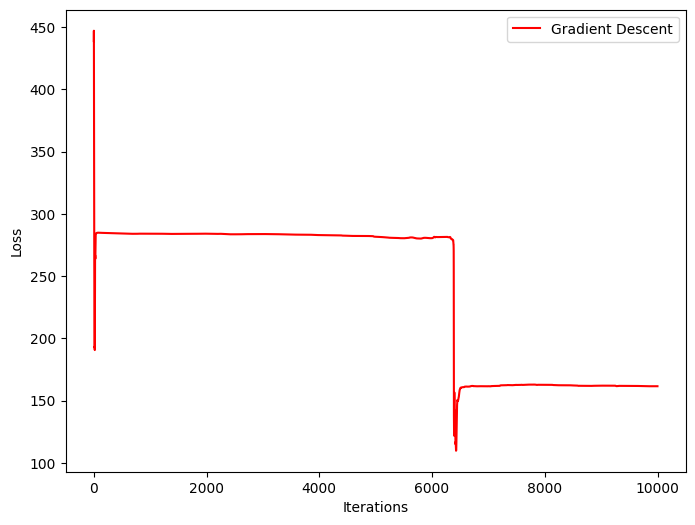

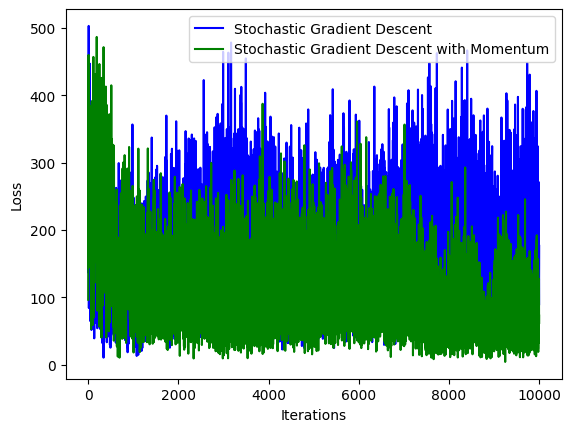

In [31]:
from matplotlib import pyplot

# Plotting Loss Progression
pyplot.figure(figsize=(8, 6))
pyplot.plot(GD, "r-", label="Gradient Descent")
pyplot.xlabel("Iterations")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.show()

pyplot.plot(SGD, "b-", label="Stochastic Gradient Descent")
pyplot.plot(SGD_Mo, "g-", label="Stochastic Gradient Descent with Momentum")
pyplot.xlabel("Iterations")
pyplot.ylabel("Loss")
pyplot.legend()
pyplot.show()

The first graph for simple gradient descent of the full dataset, has these two very steep drops followed by a short adjust to a plateau for a few thousand iterations. We are unsure what has gone wrong with our code to cause such a graph.

This final graph shows that our network is not able to converge for stochastic gradient descent with and without monentum method. We are not totally sure that what is wrong with the code to cause this and would love to know what is wrong.

### Task 10: Example Evaluation (optional)

We want to see what the network has learned.
Therefore, we evaluate some data points that would represent a typical Swiss student (except for the school entry, where we select one of them randomly).
You can select a specific example, but you can also imagine a student.
Please refer to https://archive.ics.uci.edu/ml/datasets/Student+Performance on possible values and the implementation in Tasks 1 and 2 on how to generate an input sample $\vec x$ for our network. Also, remember that input data need to be standardized before feeding it to the network. 

Compute the scores that your student would likely get by asking the network, using the parameters $\Theta$ optimized with stochastic gradient descent.



In [ ]:
# select a specific example
example = numpy.array([[
  1.,    # BIAS
  school = ['GP', 'MS'],   # school (select -1 or 1)
  gender = ['M', 'F'],   # gender
  age = [range(15, 22)],   # age
  address = ['U', 'R'],   # adress
  famsize = ['LE3', 'GT3'],   # family size
  Pstatus = ['T', 'A'],   # parents living together
  Medu = [0,1,2,3,4],   # mother education
  Fedu = [0,1,2,3,4],   # father education
  traveltime = [1,2,3,4],  # travel time
  studytime = [1,2,3,4],   # study time
  failures = [1,2,3,4],   # class failure before

  schoolsup = ['Y','N'],   # support from school
  famsup = ['Y','N'],   # support from the family
  paid = ['Y','N'],   # paid extra support 
  activities = ['Y','N'],   # out-of-school activities
  nursery = ['Y','N'],   # nursery school
  higher = ['Y','N'],   # want to do higher ed
  internet = ['Y','N'],   # internet access
  romantic = ['Y','N'],   # romantic relation

  famrel = [1,2,3,4,5],   # relation to family
  freetime  = [1,2,3,4,5],   # amount of free time
  goout = [1,2,3,4,5],   # go out with peers
  Dalc = [1,2,3,4,5],   # alcoholic drinks during the week
  Walc = [1,2,3,4,5],   # alcoholic drinks in the weekend
  Health  = [1,2,3,4,5],   # health status
  absence = [range(0,93)]    # days of absence
]]).T

# compute network output
prediction = ...
print("Prediction :\t", prediction)

### Task 11: Influence of Data Dimensions (optional)


For some dimensions in the input feature $\vec x$, we want to test how different input values for this dimension would influence the outcome.
Particularly, we test:

  * Gender at index $d=2$: change between male ($1$) and female ($-1$)
  * Weekly study time at index $d=10$: vary in the range $[1,4]$ 
  * Past Failures at index $d=11$: vary in range $[0,3]$ 
  * Additional classes at index $d=14$: change between yes ($1$) and no ($-1$)
  * Romantic relations at index $d=19$: change between yes ($1$) and no ($-1$)
  * Weekday alcohol consumption at index $d=23$: varies in the range $[1,6]$.

Note that the indexes include the fact that we are omitting some input dimensions, so they might differ from what is listed on the webpage.

Did you expect this output?



In [ ]:
# implement a way to modify the input at a given index with certain values
# and to predict and print the network output for this modification
...
# run this with the 4 modifications and their according to values as seen above
...